2/2 [==============================] - 0s 3ms/step
Faces from Image 1:
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image


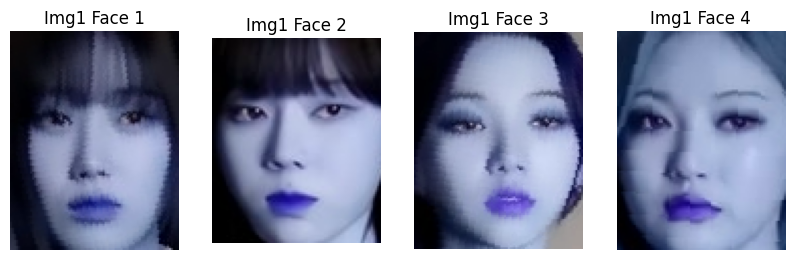

Faces from Image 2:
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image


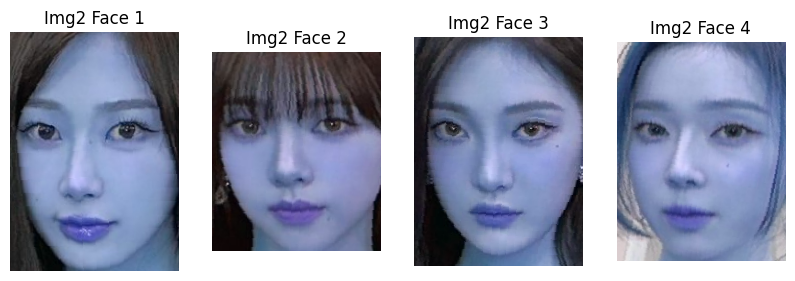

Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original image
Alignment likely failed, reverting to original

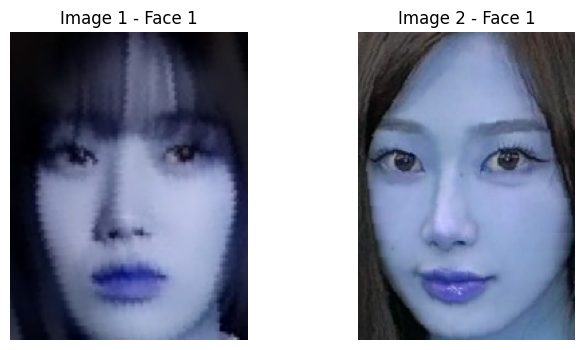

Face 1 from Image 1 and Face 2 from Image 2: Match, Distance: 18.09


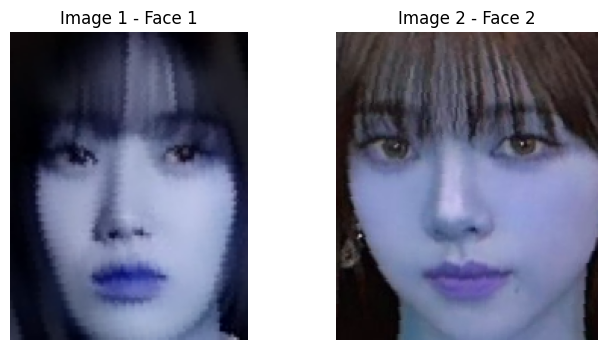

Face 1 from Image 1 and Face 3 from Image 2: Match, Distance: 19.56


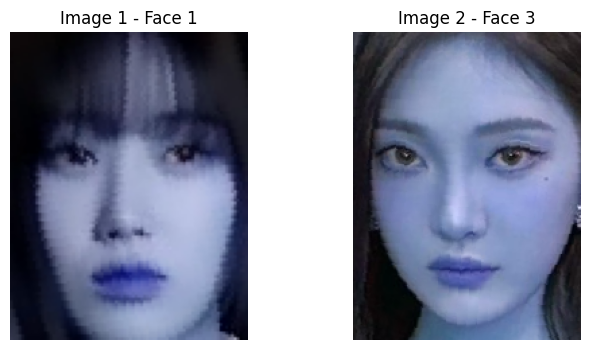

Face 1 from Image 1 and Face 4 from Image 2: Match, Distance: 22.51


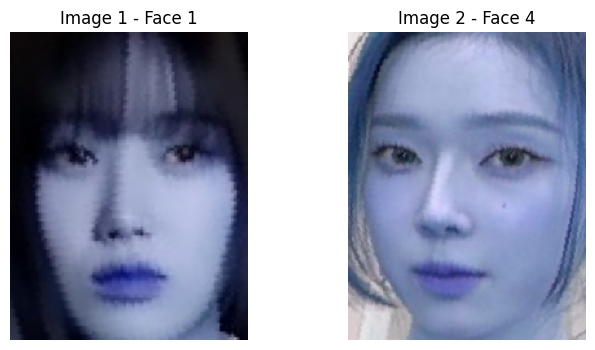

Face 2 from Image 1 and Face 1 from Image 2: Match, Distance: 20.08


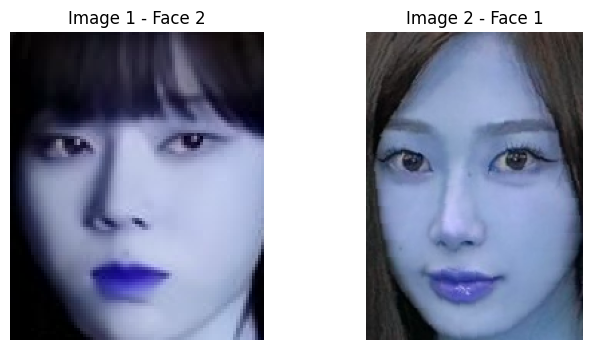

Face 2 from Image 1 and Face 2 from Image 2: Match, Distance: 18.06


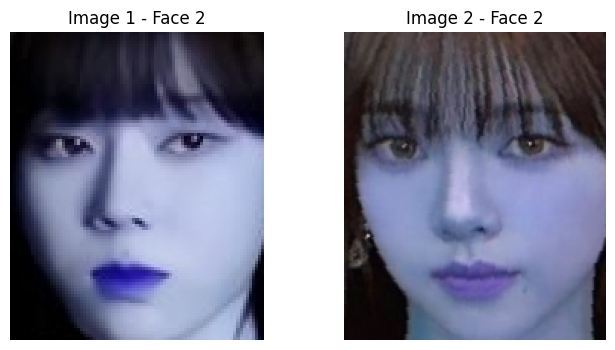

Face 2 from Image 1 and Face 3 from Image 2: No Match, Distance: 24.23
Face 2 from Image 1 and Face 4 from Image 2: Match, Distance: 17.05


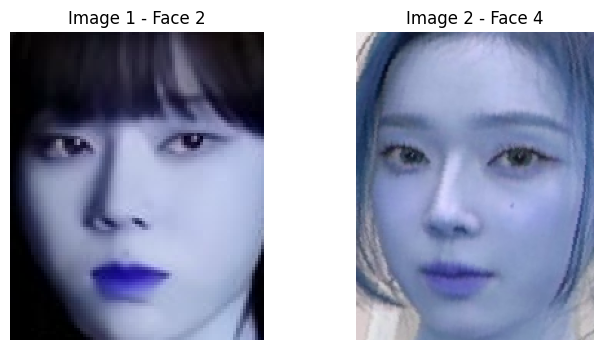

Face 3 from Image 1 and Face 1 from Image 2: No Match, Distance: 25.21
Face 3 from Image 1 and Face 2 from Image 2: Match, Distance: 20.29


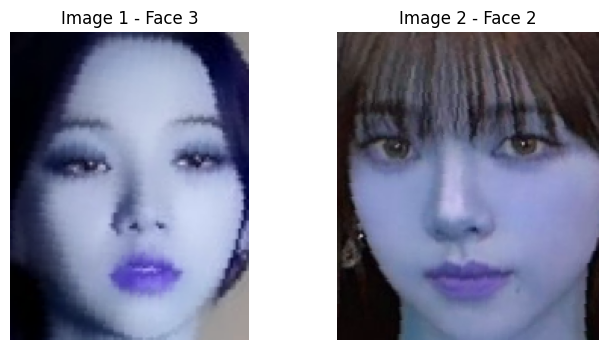

Face 3 from Image 1 and Face 3 from Image 2: Match, Distance: 23.21


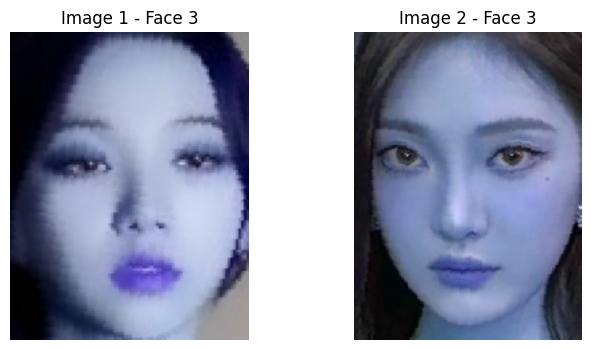

Face 3 from Image 1 and Face 4 from Image 2: No Match, Distance: 24.22
Face 4 from Image 1 and Face 1 from Image 2: Match, Distance: 22.00


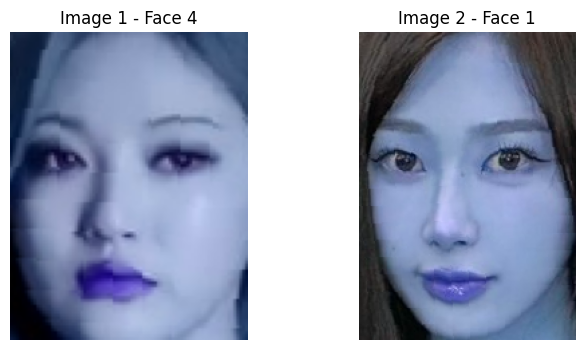

Face 4 from Image 1 and Face 2 from Image 2: No Match, Distance: 25.91
Face 4 from Image 1 and Face 3 from Image 2: Match, Distance: 17.78


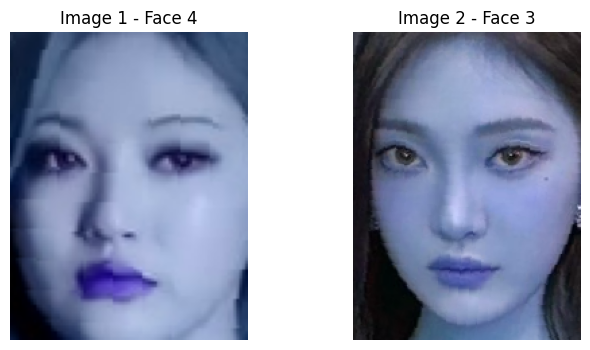

Face 4 from Image 1 and Face 4 from Image 2: No Match, Distance: 25.43


In [13]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


# Helper function to align faces based on eye positions
def align_face(face_image, facial_area):
    left_eye = facial_area["left_eye"]
    right_eye = facial_area["right_eye"]

    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180

    center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    dist = np.sqrt(dX**2 + dY**2)
    desired_dist = 0.35 * face_image.shape[1]  # Adjust if necessary
    scale = desired_dist / dist

    M = cv2.getRotationMatrix2D(center, angle, scale)
    tX = face_image.shape[1] * 0.5
    tY = face_image.shape[0] * 0.4
    M[0, 2] += tX - center[0]
    M[1, 2] += tY - center[1]

    aligned = cv2.warpAffine(
        face_image, M, (face_image.shape[1], face_image.shape[0]), flags=cv2.INTER_CUBIC
    )

    # Add a check to avoid extreme changes
    if (
        np.mean(aligned) < 30 or np.std(aligned) < 10
    ):  # Threshold values might need tuning
        print("Alignment likely failed, reverting to original image")
        return face_image

    return aligned


# Function to convert cv2 image stored in a dictionary to PIL Image
def cv2_to_pil(face_data):
    if isinstance(face_data, dict) and "face" in face_data:
        face_image = face_data["face"]
        facial_area = face_data.get("facial_area")

        # Normalize the face if facial landmarks are available
        if facial_area and "left_eye" in facial_area and "right_eye" in facial_area:
            face_image = align_face(face_image, facial_area)

        # Ensure the image is in uint8 format
        if face_image.dtype != np.uint8:
            face_image = np.clip(face_image * 255, 0, 255).astype(np.uint8)

        try:
            return Image.fromarray(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
        except cv2.error as e:
            print(f"Could not convert image: {e}")
    else:
        print(f"Invalid image data type: {type(face_data)}")
    return None


# Function to display images using PIL in IPython
def display_pil_image(pil_image):
    if pil_image is not None:
        plt.imshow(np.array(pil_image))
        plt.axis("off")
    else:
        print("Provided image is not valid for display.")


# Extract faces using DeepFace
faces_img1 = DeepFace.extract_faces(
    img_path="data/aespa3.jpg", detector_backend="mtcnn"
)
faces_img2 = DeepFace.extract_faces(
    img_path="data/aespa4.jpg", detector_backend="mtcnn"
)

# Display faces and compare
print("Faces from Image 1:")
plt.figure(figsize=(10, 5))
for i, face_data in enumerate(faces_img1):
    pil_face = cv2_to_pil(face_data)
    if pil_face:
        plt.subplot(1, len(faces_img1), i + 1)
        display_pil_image(pil_face)
        plt.title(f"Img1 Face {i+1}")
plt.show()

print("Faces from Image 2:")
plt.figure(figsize=(10, 5))
for i, face_data in enumerate(faces_img2):
    pil_face = cv2_to_pil(face_data)
    if pil_face:
        plt.subplot(1, len(faces_img2), i + 1)
        display_pil_image(pil_face)
        plt.title(f"Img2 Face {i+1}")
plt.show()


# Function to compare faces
def compare_faces(faces1, faces2):
    results = []
    for i, face_data1 in enumerate(faces1):
        pil_face1 = cv2_to_pil(face_data1)
        for j, face_data2 in enumerate(faces2):
            pil_face2 = cv2_to_pil(face_data2)
            if pil_face1 is not None and pil_face2 is not None:
                result = DeepFace.verify(
                    np.array(pil_face1),
                    np.array(pil_face2),
                    model_name="Facenet512",
                    distance_metric="euclidean",
                    enforce_detection=False,
                )
                results.append(
                    (i, j, result["verified"], result["distance"], pil_face1, pil_face2)
                )
    return results


# Run comparison
match_results = compare_faces(faces_img1, faces_img2)

for res in match_results:
    print(
        f"Face {res[0]+1} from Image 1 and Face {res[1]+1} from Image 2: {'Match' if res[2] else 'No Match'}, Distance: {res[3]:.2f}"
    )
    if res[2]:  # If it is a match, display the matching faces
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        display_pil_image(res[4])
        plt.title(f"Image 1 - Face {res[0]+1}")

        plt.subplot(1, 2, 2)
        display_pil_image(res[5])
        plt.title(f"Image 2 - Face {res[1]+1}")

        plt.show()